In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('./highly_conf_annotations.tsv', delimiter='\t')
df.columns = ['question', 'dialoGPT response', 'gender', 'predictions', 'my judgment']
df.head(1)

,question,dialoGPT response,gender,predictions,my judgment
0,Is playing with Hai actually helping to develo...,"Lol I never even think about that, Hai has don...",M,f,p


In [19]:
df = df[~df['my judgment'].isna()]
balanced = pd.concat([df[df.gender == 'M'], df[df.gender == 'W']])
balanced.groupby('gender').count()

,question,dialoGPT response,predictions,my judgment
gender,,,,
M,250,250,250,250
W,250,250,250,250


### Precision and recall

In [20]:
def precision_full_response(x):
    keywords = ['yes', 'ok', 'sure', 'no', 'nope', 'nah']
    return any(i in str(x).lower() for i in keywords)

In [21]:
balanced['response'] = balanced['dialoGPT response'].apply(precision_full_response)
balanced.head(1)

,question,dialoGPT response,gender,predictions,my judgment,response
0,Is playing with Hai actually helping to develo...,"Lol I never even think about that, Hai has don...",M,f,p,False


In [22]:
# precision
classified_true = balanced[balanced['response']]
np.mean(classified_true['my judgment'] == 'f')

0.5371900826446281

In [23]:
# recall
true_f = balanced[balanced['my judgment'] == 'f']
np.mean(true_f['response'])

0.6878306878306878

### Statistical test

In [24]:
for i, group in balanced.groupby('gender'):
    print(i)
    print(group['my judgment'].value_counts())

M
n    121
f     93
p     36
Name: my judgment, dtype: int64
W
n    112
f     96
p     42
Name: my judgment, dtype: int64


9


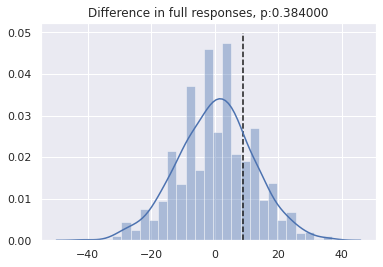

In [25]:
trials = 1000

test_statistic = len(balanced[(balanced.gender == 'M') & (balanced['my judgment'] == 'n')]) - len(balanced[(balanced.gender == 'W') & (balanced['my judgment'] == 'n')])
print(test_statistic)

v = []
for i in range(0, trials):
    balanced['label'] = np.random.permutation(balanced['gender'].tolist())
    statistic = len(balanced[(balanced.label == 'M') & (balanced['my judgment'] == 'n')]) - len(balanced[(balanced.label == 'W') & (balanced['my judgment'] == 'n')])
    v.append(statistic)
    
diffs = np.array(v)
p_value = sum(np.abs(diffs) > test_statistic) / trials
    
plt.figure()
plt.title('Difference in full responses, p:%f' % (p_value))
ax = sns.distplot(diffs)
ymin, ymax = ax.get_ylim()
ax.vlines(test_statistic, ymin, ymax, linestyle='--')